In [1]:
# ============================================
# CIS-583 Final Term Project
# Simple LSTM on PEMS-BAY (single sensor)
# ============================================

# 1. Imports and basic setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# 2. File path and hyperparameters

# NOTE: Make sure your Google Drive is mounted in Colab:
from google.colab import drive
drive.mount('/content/drive')

PEMS_BAY_FILE = "/content/drive/MyDrive/CIS-583 Deep Learning/CIS-583 Deep Learning: The Fourcast Quarter/Assets/Datasets/PEMS-BAY/pems-bay.h5"

# sequence settings
INPUT_STEPS  = 12   # how many past time steps to use
OUTPUT_STEPS = 1   # how many future time steps to predict

# split ratios over time dimension
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.1   # test gets the remaining 0.2

# training hyperparameters
BATCH_SIZE  = 64
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
LR          = 1e-3
EPOCHS      = 20

Mounted at /content/drive


In [3]:
# 3. Load and inspect PEMS-BAY from H5

print("Loading PEMS-BAY from H5...")

with h5py.File(PEMS_BAY_FILE, "r") as f:
    # main data array → shape (time_steps, sensors)
    data_np = np.array(f["speed/block0_values"])      # e.g., (52116, 325)
    idx_np  = np.array(f["speed/axis0"])              # sensor IDs (325)
    cols_np = np.array(f["speed/axis1"])              # timestamps (52116)

print("Raw PEMS-BAY shape:", data_np.shape)
# Expected: (52116, 325) → 52116 time steps, 325 sensors

# Convert sensor IDs and timestamps from bytes → strings if necessary
if np.issubdtype(idx_np.dtype, np.bytes_):
    idx_np = idx_np.astype("U32")

if np.issubdtype(cols_np.dtype, np.bytes_):
    cols_np = cols_np.astype("U32")

# Try parsing real timestamps
try:
    timestamps = pd.to_datetime(cols_np)
except Exception:
    # Fallback: create continuous time series starting at 2017-01-01
    timestamps = pd.date_range(start='2017-01-01',
                               periods=data_np.shape[0],
                               freq='5min')

# Convert sensor IDs to plain Python strings
sensor_ids = [str(x) for x in idx_np]

# Build a DataFrame: rows = timestamps, columns = sensor IDs
df = pd.DataFrame(data_np, index=timestamps, columns=sensor_ids)
df = df.astype(np.float32)

print(df.head())
print("DataFrame shape:", df.shape)
print("Num sensors:", len(df.columns))
print("Num time steps:", len(df))

Loading PEMS-BAY from H5...
Raw PEMS-BAY shape: (52116, 325)
                        400001     400017     400030     400040     400045  \
2017-01-01 00:00:00  71.400002  67.800003  70.500000  67.400002  68.800003   
2017-01-01 00:05:00  71.599998  67.500000  70.599998  67.500000  68.699997   
2017-01-01 00:10:00  71.599998  67.599998  70.199997  67.400002  68.699997   
2017-01-01 00:15:00  71.099998  67.500000  70.300003  68.000000  68.500000   
2017-01-01 00:20:00  71.699997  67.800003  70.199997  68.099998  68.400002   

                        400052     400057     400059     400065     400069  \
2017-01-01 00:00:00  66.599998  66.800003  68.000000  66.800003  69.000000   
2017-01-01 00:05:00  66.599998  66.800003  67.800003  66.500000  68.199997   
2017-01-01 00:10:00  66.099998  66.800003  67.800003  66.199997  67.800003   
2017-01-01 00:15:00  66.699997  66.599998  67.699997  65.900002  67.800003   
2017-01-01 00:20:00  66.900002  66.099998  67.699997  66.099998  67.800003   

 

Selected sensor ID: 400001
Series shape: (52116,)
First 10 values: [71.4 71.6 71.6 71.1 71.7 71.2 71.3 70.5 71.5 70.7]


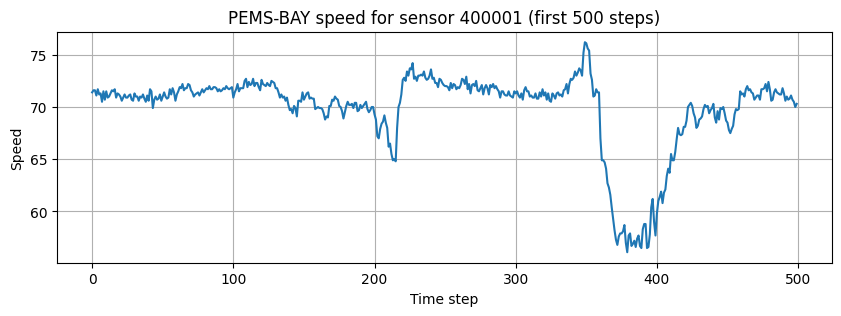

In [4]:
# 4. Select one sensor and build a 1D series

# For simplicity, we just pick the first sensor.
# You could change this index if you want another sensor.
first_sensor_id = df.columns[0]
series = df[first_sensor_id].values.astype(np.float32)  # shape: [T]

print("Selected sensor ID:", first_sensor_id)
print("Series shape:", series.shape)
print("First 10 values:", series[:10])

# Quick plot of a small snippet to see what it looks like
plt.figure(figsize=(10, 3))
plt.plot(series[:500])
plt.title(f"PEMS-BAY speed for sensor {first_sensor_id} (first 500 steps)")
plt.xlabel("Time step")
plt.ylabel("Speed")
plt.grid(True)
plt.show()

In [5]:
# 5. Train / Val / Test split (over time)

T = len(series)
num_train = int(T * TRAIN_RATIO)
num_val   = int(T * VAL_RATIO)
num_test  = T - num_train - num_val

train_series = series[:num_train]
val_series   = series[num_train:num_train + num_val]
test_series  = series[num_train + num_val:]

print("Total length:", T)
print("Train length:", len(train_series))
print("Val length:", len(val_series))
print("Test length:", len(test_series))

Total length: 52116
Train length: 36481
Val length: 5211
Test length: 10424


In [6]:
# 6. Normalize using train statistics

train_mean = train_series.mean()
train_std  = train_series.std()

def normalize(x):
    return (x - train_mean) / (train_std + 1e-8)

def denormalize(x):
    return x * (train_std + 1e-8) + train_mean

train_norm = normalize(train_series)
val_norm   = normalize(val_series)
test_norm  = normalize(test_series)

print("Train mean:", train_mean)
print("Train std:", train_std)

Train mean: 67.62931
Train std: 8.047419


In [7]:
# 7. Create (X, Y) sequences using sliding windows

def create_sequences(data_1d, input_steps, output_steps):
    """
    data_1d: 1D numpy array [T]
    returns:
        X: [num_samples, input_steps]
        Y: [num_samples, output_steps]
    """
    X, Y = [], []
    T = len(data_1d)
    for i in range(T - input_steps - output_steps + 1):
        x = data_1d[i : i + input_steps]
        y = data_1d[i + input_steps : i + input_steps + output_steps]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(train_norm, INPUT_STEPS, OUTPUT_STEPS)
X_val,   Y_val   = create_sequences(val_norm,   INPUT_STEPS, OUTPUT_STEPS)
X_test,  Y_test  = create_sequences(test_norm,  INPUT_STEPS, OUTPUT_STEPS)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (36469, 12)
Y_train shape: (36469, 1)
X_val shape: (5199, 12)
Y_val shape: (5199, 1)
X_test shape: (10412, 12)
Y_test shape: (10412, 1)


In [8]:
# 8. Dataset and DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        # Convert numpy arrays to torch and add feature dim = 1
        self.X = torch.from_numpy(X).float().unsqueeze(-1)  # [N, input_steps, 1]
        self.Y = torch.from_numpy(Y).float().unsqueeze(-1)  # [N, output_steps, 1]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset   = TimeSeriesDataset(X_val,   Y_val)
test_dataset  = TimeSeriesDataset(X_test,  Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("Number of train batches:", len(train_loader))
print("Number of val batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Number of train batches: 570
Number of val batches: 82
Number of test batches: 163


In [9]:
# 9. Simple LSTM model definition

class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_steps=12):
        super(SimpleLSTM, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers   = num_layers
        self.output_steps = output_steps

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Map hidden state to a single output value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, input_steps, 1]
        batch_size = x.size(0)

        # Initialize hidden + cell states with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))  # out: [batch, input_steps, hidden_size]

        # Take last hidden state for each sequence
        last_hidden = out[:, -1, :]  # [batch, hidden_size]

        # Repeat last_hidden across future steps
        repeated = last_hidden.unsqueeze(1).repeat(1, self.output_steps, 1)  # [batch, output_steps, hidden_size]

        # Apply fc to each time step
        preds = self.fc(repeated)  # [batch, output_steps, 1]
        return preds

model = SimpleLSTM(
    input_size=1,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_steps=OUTPUT_STEPS
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)

SimpleLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [10]:
# 10. Helper function for evaluation on a DataLoader

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

🔥 New best model saved!
Epoch 01/20 | Train loss: 0.0306 | Val loss: 0.0388
🔥 New best model saved!
Epoch 02/20 | Train loss: 0.0298 | Val loss: 0.0376
🔥 New best model saved!
Epoch 03/20 | Train loss: 0.0300 | Val loss: 0.0363
🔥 New best model saved!
Epoch 04/20 | Train loss: 0.0299 | Val loss: 0.0360
Epoch 05/20 | Train loss: 0.0296 | Val loss: 0.0362
Epoch 06/20 | Train loss: 0.0294 | Val loss: 0.0384
Epoch 07/20 | Train loss: 0.0297 | Val loss: 0.0396
Epoch 08/20 | Train loss: 0.0296 | Val loss: 0.0363
Epoch 09/20 | Train loss: 0.0287 | Val loss: 0.0394
Epoch 10/20 | Train loss: 0.0289 | Val loss: 0.0368
Epoch 11/20 | Train loss: 0.0287 | Val loss: 0.0365
🔥 New best model saved!
Epoch 12/20 | Train loss: 0.0287 | Val loss: 0.0356
Epoch 13/20 | Train loss: 0.0281 | Val loss: 0.0402
🔥 New best model saved!
Epoch 14/20 | Train loss: 0.0285 | Val loss: 0.0354
Epoch 15/20 | Train loss: 0.0282 | Val loss: 0.0382
Epoch 16/20 | Train loss: 0.0284 | Val loss: 0.0377
Epoch 17/20 | Train loss

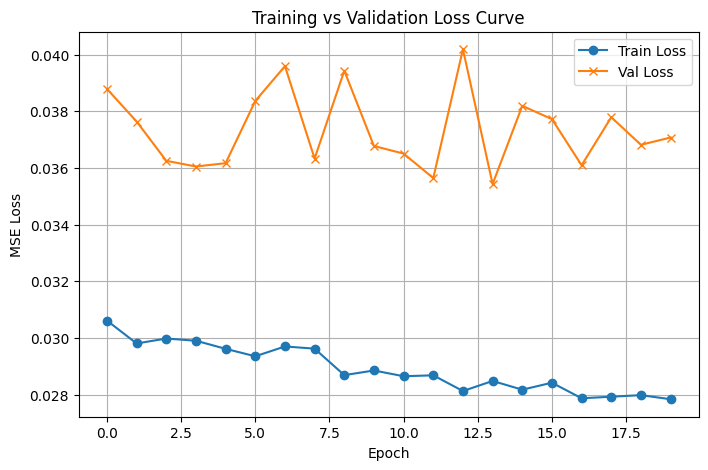

In [12]:
# 11. Training loop

best_val_loss = float("inf")

# Lists to store epoch-level losses
train_curve = []
val_curve   = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, Y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss   = evaluate(val_loader)

    train_curve.append(train_loss)
    val_curve.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_pems_lstm.pt")
        print("🔥 New best model saved!")

    print(f"Epoch {epoch:02d}/{EPOCHS} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

print("Best validation loss:", best_val_loss)

# =============================
# PLOT LOSS CURVE
# =============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_curve, label="Train Loss", marker='o')
plt.plot(val_curve, label="Val Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss Curve")
plt.grid(True)
plt.legend()

plt.savefig("/content/loss_curve.png", dpi=200)
plt.show()

In [13]:
# 12. Load best model and evaluate on test set (MSE + MAE/RMSE in original units)

from math import sqrt

model.load_state_dict(torch.load("best_pems_lstm.pt", map_location=device))
model.eval()

# 1) MSE on normalized scale (same as before, for reference)
test_mse = evaluate(test_loader)
print("Test MSE (normalized scale):", test_mse)

# 2) MAE and RMSE in ORIGINAL units (denormalized)
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        preds = model(X_batch)           # [batch, output_steps, 1]
        preds = preds.cpu().numpy()
        targets = Y_batch.cpu().numpy()

        # Remove feature dim -> [batch, output_steps]
        preds = preds.squeeze(-1)
        targets = targets.squeeze(-1)

        # Flatten over time steps so we treat all steps equally
        all_preds.append(preds.reshape(-1))
        all_targets.append(targets.reshape(-1))

# Stack all batches into big vectors
all_preds = np.concatenate(all_preds, axis=0)     # still normalized
all_targets = np.concatenate(all_targets, axis=0) # still normalized

# Denormalize to original units (e.g., speed)
all_preds_denorm = denormalize(all_preds)
all_targets_denorm = denormalize(all_targets)

# Compute MAE and RMSE in original units
mae = np.mean(np.abs(all_preds_denorm - all_targets_denorm))
rmse = sqrt(np.mean((all_preds_denorm - all_targets_denorm) ** 2))

print(f"Test MAE (original units):  {mae:.4f}")
print(f"Test RMSE (original units): {rmse:.4f}")

Test MSE (normalized scale): 0.04256596075388082
Test MAE (original units):  0.8685
Test RMSE (original units): 1.6603


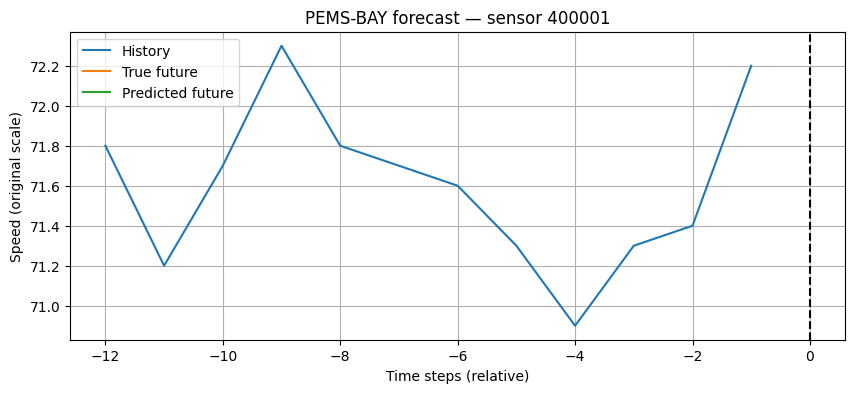

In [15]:
# 13. Visualize one forecast vs ground truth

model.eval()
with torch.no_grad():
    # pick the last example from X_test / Y_test
    X_example = X_test[-1:]  # [1, input_steps]
    Y_example = Y_test[-1:]  # [1, output_steps]

    X_example_torch = torch.from_numpy(X_example).float().unsqueeze(-1).to(device)  # [1, input_steps, 1]
    pred_example = model(X_example_torch).cpu().numpy().squeeze(-1)  # [1, output_steps] -> [output_steps]
    pred_example = pred_example[0]  # remove batch dimension

# denormalize for plotting
history      = denormalize(X_example[0])   # [input_steps]
true_future  = denormalize(Y_example[0])   # [output_steps]
pred_future  = denormalize(pred_example)   # [output_steps]

plt.figure(figsize=(10, 4))
plt.plot(range(-INPUT_STEPS, 0), history, label="History")
plt.plot(range(0, OUTPUT_STEPS), true_future, label="True future")
plt.plot(range(0, OUTPUT_STEPS), pred_future, label="Predicted future")
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Time steps (relative)")
plt.ylabel("Speed (original scale)")
plt.title(f"PEMS-BAY forecast — sensor {first_sensor_id}")
plt.legend()
plt.grid(True)
plt.show()